# Visualization Variant Painting Images and Cells

In [1]:
import os
import glob
import polars as pl
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from tqdm import tqdm
import re
import sys
sys.path.append("../../../8.1_upstream_analysis_runxi/2.raw_img_qc/scripts")
from img_utils import *

TIFF_IMGS_DIR = "../../../8.1_upstream_analysis_runxi/2.raw_img_qc/inputs/images"
IMGS_QC_DIR = "../../../8.1_upstream_analysis_runxi/2.raw_img_qc/outputs/1.plate_bg_summary"
CELL_CHANGES = ["localization", "morphology"]
# channel_dict

## 1. Loading meta data and variant classification

In [2]:
BIO_REP_BATCHES = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]
COMBINED_BIO_REP_DIR = "2024_02_Batch_7-8"

# BIO_REP_BATCHES = ["2025_03_17_Batch_15", "2025_03_17_Batch_16"]
# COMBINED_BIO_REP_DIR = "2025_03_Batch_15-16"

### 1.1 Read in the meta data

In [3]:
meta_data = pl.DataFrame()
plate_map_dirs = [
    f"../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap/"
    for batch_id in BIO_REP_BATCHES
]
# print(plate_map_dirs)

for plate_map_dir in plate_map_dirs:
    for plate_map in os.listdir(plate_map_dir):
        if plate_map.endswith(".txt"):
            plate_map_path = os.path.join(plate_map_dir, plate_map)
            plate_map_data = pl.read_csv(plate_map_path, separator="\t", infer_schema_length=1000000)
            # print(plate_map_data)
            if meta_data.is_empty():
                meta_data = plate_map_data
            else:
                meta_data = pl.concat([meta_data, plate_map_data], how="vertical_relaxed")
    break ## Only need the first bio rep batch meta data

# meta_data = meta_data.with_columns(
#     pl.col("imaging_plate_R1").str.extract(r"^([^_]+)", 1).alias("imaging_plate_R1"),
#     pl.col("imaging_plate_R2").str.extract(r"^([^_]+)", 1).alias("imaging_plate_R2")
# )
display(meta_data)

shape: (1_480, 32)
┌─────────────┬────────────┬────────────┬────────┬───┬──────┬────────────┬────────────┬────────────┐
│ plate_map_n ┆ well_posit ┆ control_ty ┆ symbol ┆ … ┆ c384 ┆ r384_lette ┆ gene_symbo ┆ symbol_ori │
│ ame         ┆ ion        ┆ pe         ┆ ---    ┆   ┆ ---  ┆ r          ┆ l          ┆ ginal      │
│ ---         ┆ ---        ┆ ---        ┆ str    ┆   ┆ i64  ┆ ---        ┆ ---        ┆ ---        │
│ str         ┆ str        ┆ str        ┆        ┆   ┆      ┆ str        ┆ str        ┆ str        │
╞═════════════╪════════════╪════════════╪════════╪═══╪══════╪════════════╪════════════╪════════════╡
│ B7A1R1_P1   ┆ A01        ┆ disease_wt ┆ ACSF3  ┆ … ┆ 1    ┆ A          ┆ ACSF3      ┆ ACSF3      │
│ B7A1R1_P1   ┆ C01        ┆ allele     ┆ ACSF3  ┆ … ┆ 1    ┆ C          ┆ ACSF3      ┆ ACSF3      │
│ B7A1R1_P1   ┆ E01        ┆ allele     ┆ ACSF3  ┆ … ┆ 1    ┆ E          ┆ ACSF3      ┆ ACSF3      │
│ B7A1R1_P1   ┆ G01        ┆ allele     ┆ ACSF3  ┆ … ┆ 1    ┆ G          ┆ ACSF3      ┆ ACSF3      │
│ B7A1R1_P1   ┆ I01        ┆ allele     ┆ ACSF3  ┆ … ┆ 1    ┆ I          ┆ ACSF3      ┆ ACSF3      │
│ …           ┆ …          ┆ …          ┆ …      ┆ … ┆ …    ┆ …          ┆ …          ┆ …          │
│ B7A1R1_P2   ┆ H24        ┆ disease_wt ┆ MAP2K2 ┆ … ┆ 24   ┆ H          ┆ MAP2K2     ┆ MAP2K2     │
│ B7A1R1_P2   ┆ J24        ┆ allele     ┆ MAP2K2 ┆ … ┆ 24   ┆ J          ┆ MAP2K2     ┆ MAP2K2     │
│ B7A1R1_P2   ┆ L24        ┆ disease_wt ┆ MAX    ┆ … ┆ 24   ┆ L          ┆ MAX        ┆ MAX        │
│ B7A1R1_P2   ┆ N24        ┆ disease_wt ┆ MCEE   ┆ … ┆ 24   ┆ N          ┆ MCEE       ┆ MCEE       │
│ B7A1R1_P2   ┆ P24        ┆ allele     ┆ NAA10  ┆ … ┆ 24   ┆ P          ┆ NAA10      ┆ NAA10      │
└─────────────┴────────────┴────────────┴────────┴───┴──────┴────────────┴────────────┴────────────┘

In [4]:
local_wtvar = pl.read_csv(f"../../outputs/{COMBINED_BIO_REP_DIR}/altered_local_summary_auroc.csv")
morph_wtvar = pl.read_csv(f"../../outputs/{COMBINED_BIO_REP_DIR}/altered_morph_summary_auroc.csv")
# local_wtvar.filter(pl.col("allele_0")=="KCNJ2_Met301Val")["AUROC_mean"].mean()

In [5]:
plate_img_qc = pl.DataFrame()

for batch_id in BIO_REP_BATCHES:
    plate_img_qc = pl.concat([plate_img_qc, pl.read_parquet(f"{IMGS_QC_DIR}/{batch_id}/plate_well_sum_with_metrics.parquet")])

plate_img_qc

shape: (61_376, 18)
┌───────────────┬──────┬─────────┬────────────┬───┬────────────┬───────────┬───────────────┬───────┐
│ plate         ┆ well ┆ channel ┆ mean       ┆ … ┆ std_plate  ┆ s2n_ratio ┆ s2n_threshold ┆ is_bg │
│ ---           ┆ ---  ┆ ---     ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---           ┆ ---   │
│ str           ┆ str  ┆ str     ┆ f64        ┆   ┆ f64        ┆ f64       ┆ f64           ┆ bool  │
╞═══════════════╪══════╪═════════╪════════════╪═══╪════════════╪═══════════╪═══════════════╪═══════╡
│ 2024_01_23_B7 ┆ N12  ┆ DAPI    ┆ 187.699139 ┆ … ┆ 182.984148 ┆ 1.518293  ┆ 1.728765      ┆ true  │
│ A1R1_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_01_23_B7 ┆ H12  ┆ DAPI    ┆ 188.282493 ┆ … ┆ 182.984148 ┆ 1.560976  ┆ 1.728765      ┆ true  │
│ A1R1_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_01_23_B7 ┆ M01  ┆ DAPI    ┆ 116.386441 ┆ … ┆ 182.984148 ┆ 1.631579  ┆ 1.728765      ┆ true  │
│ A1R1_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_01_23_B7 ┆ P13  ┆ DAPI    ┆ 188.421845 ┆ … ┆ 182.984148 ┆ 1.634146  ┆ 1.728765      ┆ true  │
│ A1R1_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_01_23_B7 ┆ N22  ┆ DAPI    ┆ 186.995412 ┆ … ┆ 182.984148 ┆ 1.658537  ┆ 1.728765      ┆ true  │
│ A1R1_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ …             ┆ …    ┆ …       ┆ …          ┆ … ┆ …          ┆ …         ┆ …             ┆ …     │
│ 2024_02_05_B8 ┆ C02  ┆ Mito    ┆ 786.685071 ┆ … ┆ 861.062781 ┆ 14.665914 ┆ 1.840351      ┆ false │
│ A1R2_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_02_05_B8 ┆ J09  ┆ Mito    ┆ 814.609456 ┆ … ┆ 861.062781 ┆ 14.678715 ┆ 1.840351      ┆ false │
│ A1R2_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_02_05_B8 ┆ L07  ┆ Mito    ┆ 974.677478 ┆ … ┆ 861.062781 ┆ 14.774127 ┆ 1.840351      ┆ false │
│ A1R2_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_02_05_B8 ┆ J04  ┆ Mito    ┆ 902.200077 ┆ … ┆ 861.062781 ┆ 15.230461 ┆ 1.840351      ┆ false │
│ A1R2_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
│ 2024_02_05_B8 ┆ I09  ┆ Mito    ┆ 842.36822  ┆ … ┆ 861.062781 ┆ 15.502994 ┆ 1.840351      ┆ false │
│ A1R2_P4T2     ┆      ┆         ┆            ┆   ┆            ┆           ┆               ┆       │
└───────────────┴──────┴─────────┴────────────┴───┴────────────┴───────────┴───────────────┴───────┘

## Plot Variant Painting Images

In [6]:
out_imgs_dir = f"../../../8.2_updated_snakemake_pipeline/outputs/visualize_imgs/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(out_imgs_dir):
    os.makedirs(out_imgs_dir)

In [7]:
import subprocess

def channel_to_cmap(channel):
    if channel == "GFP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#65fe08"])
    elif channel == "DAPI":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#0000FF"])
    elif channel == "Mito":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FF0000"]) 
    elif channel == "AGP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FFFF00"]) 
    else:
        cmap = "gray"
    return cmap


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def plot_allele(pm, variant, sel_channel, auroc_df, plate_img_qc=None, site="05", max_intensity=0.99, display=False, imgs_dir=TIFF_IMGS_DIR, output_dir=out_imgs_dir):
    plt.clf()
    cmap = channel_to_cmap(sel_channel)
    channel = channel_dict[sel_channel]
    auroc = auroc_df.filter(pl.col("allele_0")==variant)["AUROC_Mean"].mean()
        
    ## get the number of wells/images per allele
    wt = variant.split("_")[0]
    wt_wells = pm.filter(pl.col("gene_allele") == wt).select("imaging_well").to_pandas().values.flatten()
    var_wells = pm.filter(pl.col("gene_allele") == variant).select("imaging_well").to_pandas().values.flatten()
    plate_map = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name").to_pandas().values.flatten()

    if len(wt_wells) > 1:
        # Get coordinates of wells
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in wt_wells])]
        # Sort wells by max distance from edges (descending)
        wt_wells = [max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]]
    pm_var = pm.filter((pl.col("imaging_well").is_in(np.concatenate([wt_wells, var_wells])))&(pl.col("plate_map_name").is_in(plate_map))).sort("node_type")
    # print(pm_var)

    fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    for wt_var, pm_row in enumerate(pm_var.iter_rows(named=True)):
        # print(pm_row)
        if pm_row["node_type"] == "allele":
            well = var_wells[0]
            allele = variant
        else:
            well = wt_wells[0]
            allele = wt

        for i in range(8):
            if i < 4:
                sel_plate = pm_row["imaging_plate_R1"]
            else:
                sel_plate = pm_row["imaging_plate_R2"]
                
            if "_" in sel_plate:
                batch_plate_map = sel_plate.split("_")[0]
            else:
                batch_plate_map = sel_plate
            
            batch = batch_dict[batch_plate_map]
            batch_img_dir = f'{imgs_dir}/{batch}/images'
            
            letter = well[0]
            row = letter_dict[letter]
            col = well[1:3]
            
            plate_img_dir = plate_dict[sel_plate][f"T{i%4+1}"]
            img_file = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"

            # print(batch, well, plate_img_dir, img_file)
            # break

            if plate_img_qc is not None:
                is_bg = plate_img_qc.filter((pl.col("plate") == plate_img_dir.split("__")[0]) & (pl.col("well") == well) & (pl.col("channel") == sel_channel))["is_bg"].to_numpy()[0]
                # print(is_bg)
            if (os.path.exists(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}")):
                img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            else:
                # Define your S3 path and local destination
                s3_path = f's3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate_img_dir}/Images/{img_file}'
                local_path = f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}"
                # Build the aws cli command
                cmd = ['aws', 's3', 'cp', '--no-sign-request', s3_path, local_path]
                # Execute the command using subprocess
                try:
                    subprocess.run(cmd, check=True)
                    print(f"Successfully downloaded from {s3_path} to {local_path}")
                except subprocess.CalledProcessError as e:
                    print(f"An error occurred: {e}")
                img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            
            plot_idx = i+wt_var*4*2
            # print(i, wt_var, plot_idx)
            axes.flatten()[plot_idx].imshow(img, vmin=0, vmax=np.percentile(img, max_intensity*100), cmap=cmap)
            plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
            axes.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
                    verticalalignment='top', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                    bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
            if is_bg:
                axes.flatten()[plot_idx].text(0.03, 0.03, "FLAG:\nOnly Background\nNoise is Detected", color='red', fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                    bbox=dict(facecolor='white', alpha=0.3, linewidth=2))
            int_95 = str(int(round(np.percentile(img, 95))))
            axes.flatten()[plot_idx].text(0.97, 0.03, f"95th Intensity:{int_95}\nSet vmax:{max_intensity*100:.0f}th perc.", color='white', fontsize=10,
                           verticalalignment='bottom', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                           bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
            axes.flatten()[plot_idx].axis("off")
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)
    if display:
        plt.show()
    if output_dir:
        fig.savefig(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}.png"), dpi=400, bbox_inches='tight')
        plt.close(fig)

<Figure size 640x480 with 0 Axes>

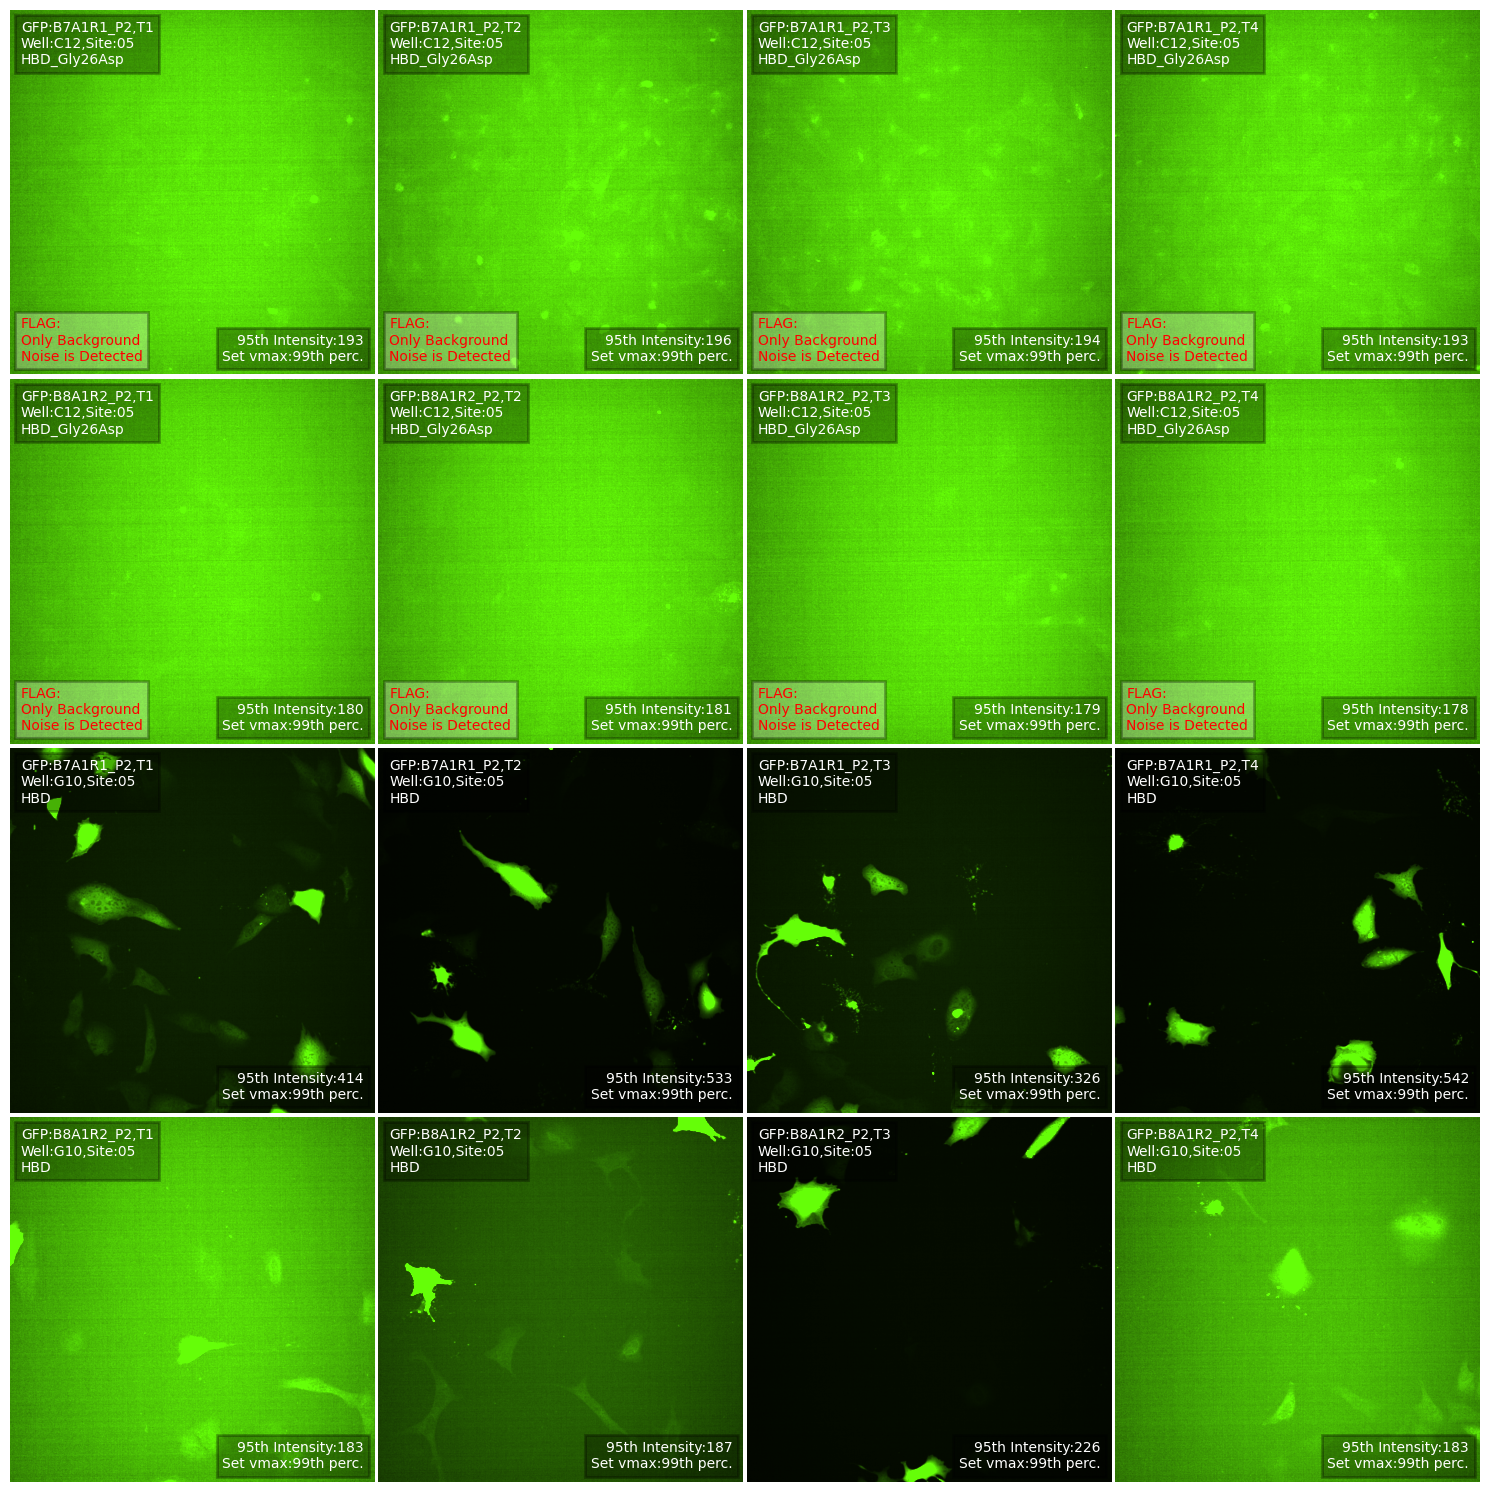

In [8]:

plot_allele(meta_data.filter(pl.col("plate_map_name").str.contains("B7")), "HBD_Gly26Asp", "GFP", auroc_df=local_wtvar, plate_img_qc=plate_img_qc, site="05", max_intensity=0.99, display=True, output_dir=out_imgs_dir)

In [ ]:
df = pl.read_csv(f"/home/shenrunx/data_storage/igvf/varchamp/ppi_misloc_hit.tsv", separator="\t")
for allele in tqdm(df["allele_0"]):
    try:
        plot_allele(meta_data.filter(pl.col("plate_map_name").str.contains("B7")), allele, "GFP", auroc_df=local_wtvar, plate_img_qc=plate_img_qc, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)
    except:
        continue

 67%|██████▋   | 72/108 [10:02<04:22,  7.30s/it]<ipython-input-7-abcf01f339ee>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
100%|██████████| 108/108 [14:59<00:00,  8.33s/it]


In [16]:
plot_allele(meta_data.filter(pl.col("plate_map_name").str.contains("B7")), "MVK_Leu255Pro", "GFP", auroc_df=local_wtvar, plate_img_qc=plate_img_qc, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)
plot_allele(meta_data.filter(pl.col("plate_map_name").str.contains("B7")), "MVK_Leu41Pro", "GFP", auroc_df=local_wtvar, plate_img_qc=plate_img_qc, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)

In [ ]:
# b78_eight_genes = ["HBD", "HPRT1", "FBP1", "TH", "PITX2", "KRT5", "GMPPB", "NMNAT1"]

local_wtvar = local_wtvar.with_columns(
    pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("gene_symbol")
)

# var2plot = local_wtvar.filter((pl.col("Altered_local_both_batches"))&((pl.col("gene_symbol").is_in(b78_eight_genes))))["allele_0"] ## batch 7-8
var2plot = local_wtvar.filter((pl.col("Altered_local_both_batches"))&((pl.col("gene_symbol").is_in(["STXBP1", "MLH1", "MVK"]))))["allele_0"] ## batch 7-8
var2plot
# local_wtvar.filter((pl.col("Altered_local_both_batches"))&((pl.col("allele_0").str.contains("GFAP"))|(pl.col("allele_0").str.contains("KCNJ2")))) ## batch 15-16

shape: (2,)
Series: 'allele_0' [str]
[
	"MVK_Leu255Pro"
	"MVK_Leu41Pro"
]

In [11]:
# plot_allele(meta_data, "KCNJ2_Met301Val", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, output_dir=out_imgs_dir)

### Output specific mislocalized alleles for investigation

In [17]:
for allele in tqdm(var2plot):
    print(allele)
    # plot_allele(meta_data.filter(pl.col("plate_map_name").str.contains("B7")), allele, "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)

100%|██████████| 2/2 [00:00<00:00, 15224.33it/s]

MVK_Leu255Pro
MVK_Leu41Pro


In [16]:
for allele in tqdm(morph_wtvar.filter((pl.col("Altered_morph_both_batches")))["allele_0"]):
    # print(allele)
    plot_allele(meta_data, allele, "AGP", auroc_df=morph_wtvar, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)
    plot_allele(meta_data, allele, "Mito", auroc_df=morph_wtvar, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)
    plot_allele(meta_data, allele, "DAPI", auroc_df=morph_wtvar, site="05", max_intensity=0.99, display=False, output_dir=out_imgs_dir)

100%|██████████| 4/4 [02:00<00:00, 30.12s/it]


## Plot Cells

In [17]:
out_cells_dir = f"../../../8.2_updated_snakemake_pipeline/outputs/visualize_cells/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(out_cells_dir):
    os.makedirs(out_cells_dir)

In [18]:
# Filter thresholds
min_area_ratio = 0.15
max_area_ratio = 0.3
min_center = 50
max_center = 1030
num_mad = 5
min_cells = 250

batch_profiles = {}
for batch_id in BIO_REP_BATCHES:
    imagecsv_dir = f"../../../8.1_upstream_analysis_runxi/2.raw_img_qc/inputs/images/{batch_id}/analysis"
    prof_path = f"../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
    # Get metadata
    profiles = pl.scan_parquet(prof_path).select(
        ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
        "Metadata_symbol", "Metadata_gene_allele", "Metadata_node_type", "Metadata_Plate",
        "Nuclei_AreaShape_Area", "Cells_AreaShape_Area", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y",
        "Cells_AreaShape_BoundingBoxMaximum_X", "Cells_AreaShape_BoundingBoxMaximum_Y", "Cells_AreaShape_BoundingBoxMinimum_X",
        "Cells_AreaShape_BoundingBoxMinimum_Y",	"Cells_AreaShape_Center_X",	"Cells_AreaShape_Center_Y",
        "Cells_Intensity_MeanIntensity_GFP", "Cells_Intensity_MedianIntensity_GFP", "Cells_Intensity_IntegratedIntensity_GFP"],
    ).collect()
    # print(profiles["Metadata_Plate"])
    # break

    # Filter based on cell to nucleus area
    profiles = profiles.with_columns(
                    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area"),
                    pl.concat_str([
                        "Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber", "Metadata_ObjectNumber",
                        ], separator="_").alias("Metadata_CellID"),
            ).filter((pl.col("Nucleus_Cell_Area") > min_area_ratio) & (pl.col("Nucleus_Cell_Area") < max_area_ratio))

    # Filter cells too close to image edge
    profiles = profiles.filter(
        ((pl.col("Nuclei_AreaShape_Center_X") > min_center) & (pl.col("Nuclei_AreaShape_Center_X") < max_center) &
        (pl.col("Nuclei_AreaShape_Center_Y") > min_center) & (pl.col("Nuclei_AreaShape_Center_Y") < max_center)),
    )

    # Calculate mean, median and mad of gfp intensity for each allele
    ## mean
    means = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MeanIntensity_GFP").mean().alias("WellIntensityMean"),
    )
    profiles = profiles.join(means, on=["Metadata_Plate", "Metadata_well_position"])
    ## median
    medians = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MedianIntensity_GFP").median().alias("WellIntensityMedian"),
    )
    profiles = profiles.join(medians, on=["Metadata_Plate", "Metadata_well_position"])
    ## mad
    profiles = profiles.with_columns(
        (pl.col("Cells_Intensity_MedianIntensity_GFP") - pl.col("WellIntensityMedian")).abs().alias("Abs_dev"),
    )
    mad = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Abs_dev").median().alias("Intensity_MAD"),
    )
    profiles = profiles.join(mad, on=["Metadata_Plate", "Metadata_well_position"])

    # Threshold is 5X
    # Used to be median well intensity + 5*mad implemented by Jess
    # Switching to mean well intensity + 5*mad implemented by Runxi
    # profiles = profiles.with_columns(
    #     (pl.col("WellIntensityMedian") + num_mad*pl.col("Intensity_MAD")).alias("Intensity_upper_threshold"), ## pl.col("WellIntensityMedian")
    #     (pl.col("WellIntensityMedian") - num_mad*pl.col("Intensity_MAD")).alias("Intensity_lower_threshold"), ## pl.col("WellIntensityMedian")
    # )
    # ## Filter by intensity MAD
    # profiles = profiles.filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") <= pl.col("Intensity_upper_threshold"),
    # ).filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") >= pl.col("Intensity_lower_threshold"),
    # )

    # Filter out alleles with fewer than 250 cells
    # keep_alleles = profiles.group_by("Metadata_gene_allele").count().filter(
    #     pl.col("count") >= min_cells,
    #     ).select("Metadata_gene_allele").to_series().to_list()
    # profiles = profiles.filter(pl.col("Metadata_gene_allele").is_in(keep_alleles))

    # add full crop coordinates
    profiles = profiles.with_columns(
        (pl.col("Nuclei_AreaShape_Center_X") - 50).alias("x_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_X") + 50).alias("x_high").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") - 50).alias("y_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") + 50).alias("y_high").round().cast(pl.Int16),
    )

    # Read in all Image.csv to get ImageNumber:SiteNumber mapping and paths
    image_dat = []
    icfs = glob.glob(os.path.join(imagecsv_dir, "**/*Image.csv"), recursive=True)
    for icf in tqdm(icfs):
        fp = icf.split('/')[-2]
        # print(fp)
        plate, well = "-".join(fp.split("-")[:-2]), fp.split("-")[-2]
        # print(plate, well)
        image_dat.append(pl.read_csv(icf).select(
            [
                "ImageNumber",
                "Metadata_Site",
                "PathName_OrigDNA",
                "FileName_OrigDNA",
                "FileName_OrigGFP",
                ],
            ).with_columns(
            pl.lit(plate).alias("Metadata_Plate"),
            pl.lit(well).alias("Metadata_well_position"),
            ))
    image_dat = pl.concat(image_dat).rename({"ImageNumber": "Metadata_ImageNumber"})

    # Create useful filepaths
    image_dat = image_dat.with_columns(
        pl.col("PathName_OrigDNA").str.replace(".*cpg0020-varchamp/", "").alias("Path_root"),
    )

    image_dat = image_dat.drop([
        "PathName_OrigDNA",
        "FileName_OrigDNA",
        "FileName_OrigGFP",
        "Path_root",
    ])
    # print(image_dat)

    # Append to profiles
    profiles = profiles.join(image_dat, on = ["Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber"])

    # Sort by allele, then image number
    profiles = profiles.with_columns(
        pl.concat_str(["Metadata_Plate", "Metadata_well_position", "Metadata_Site"], separator="_").alias("Metadata_SiteID"),
        pl.col("Metadata_gene_allele").str.replace("_", "-").alias("Protein_label"),
    )
    profiles = profiles.sort(["Protein_label", "Metadata_SiteID"])
    alleles = profiles.select("Protein_label").to_series().unique().to_list()

    batch_profiles[batch_id] = profiles

100%|██████████| 13823/13823 [00:24<00:00, 567.44it/s]


In [20]:
def crop_allele(allele: str, profile_df: pl.DataFrame, meta_plate: str, rep: str, site: str="5") -> None:
    """Crop images and save metadata as numpy arrays for one allele.

    Parameters
    ----------
    allele : String
        Name of allele to process
    profile_df : String
        Dataframe with pathname and cell coordinates
    img_dir : String
        Directory where all images are stored
    out_dir : String
        Directory where numpy arrays should be saved
    """
    allele_df = profile_df.filter(
        (pl.col("Metadata_gene_allele")==allele) &
        (pl.col("Metadata_Site")==int(site)) &
        (pl.col("Metadata_plate_map_name").str.contains(meta_plate)) &
        (pl.col("Metadata_Plate").str.contains(rep))
    )
    return allele_df

allele_df = crop_allele("GFAP_Leu357Pro", batch_profiles["2025_03_17_Batch_16"], "B16A1A2", "T4", site="5")
# allele_df

<Figure size 640x480 with 0 Axes>

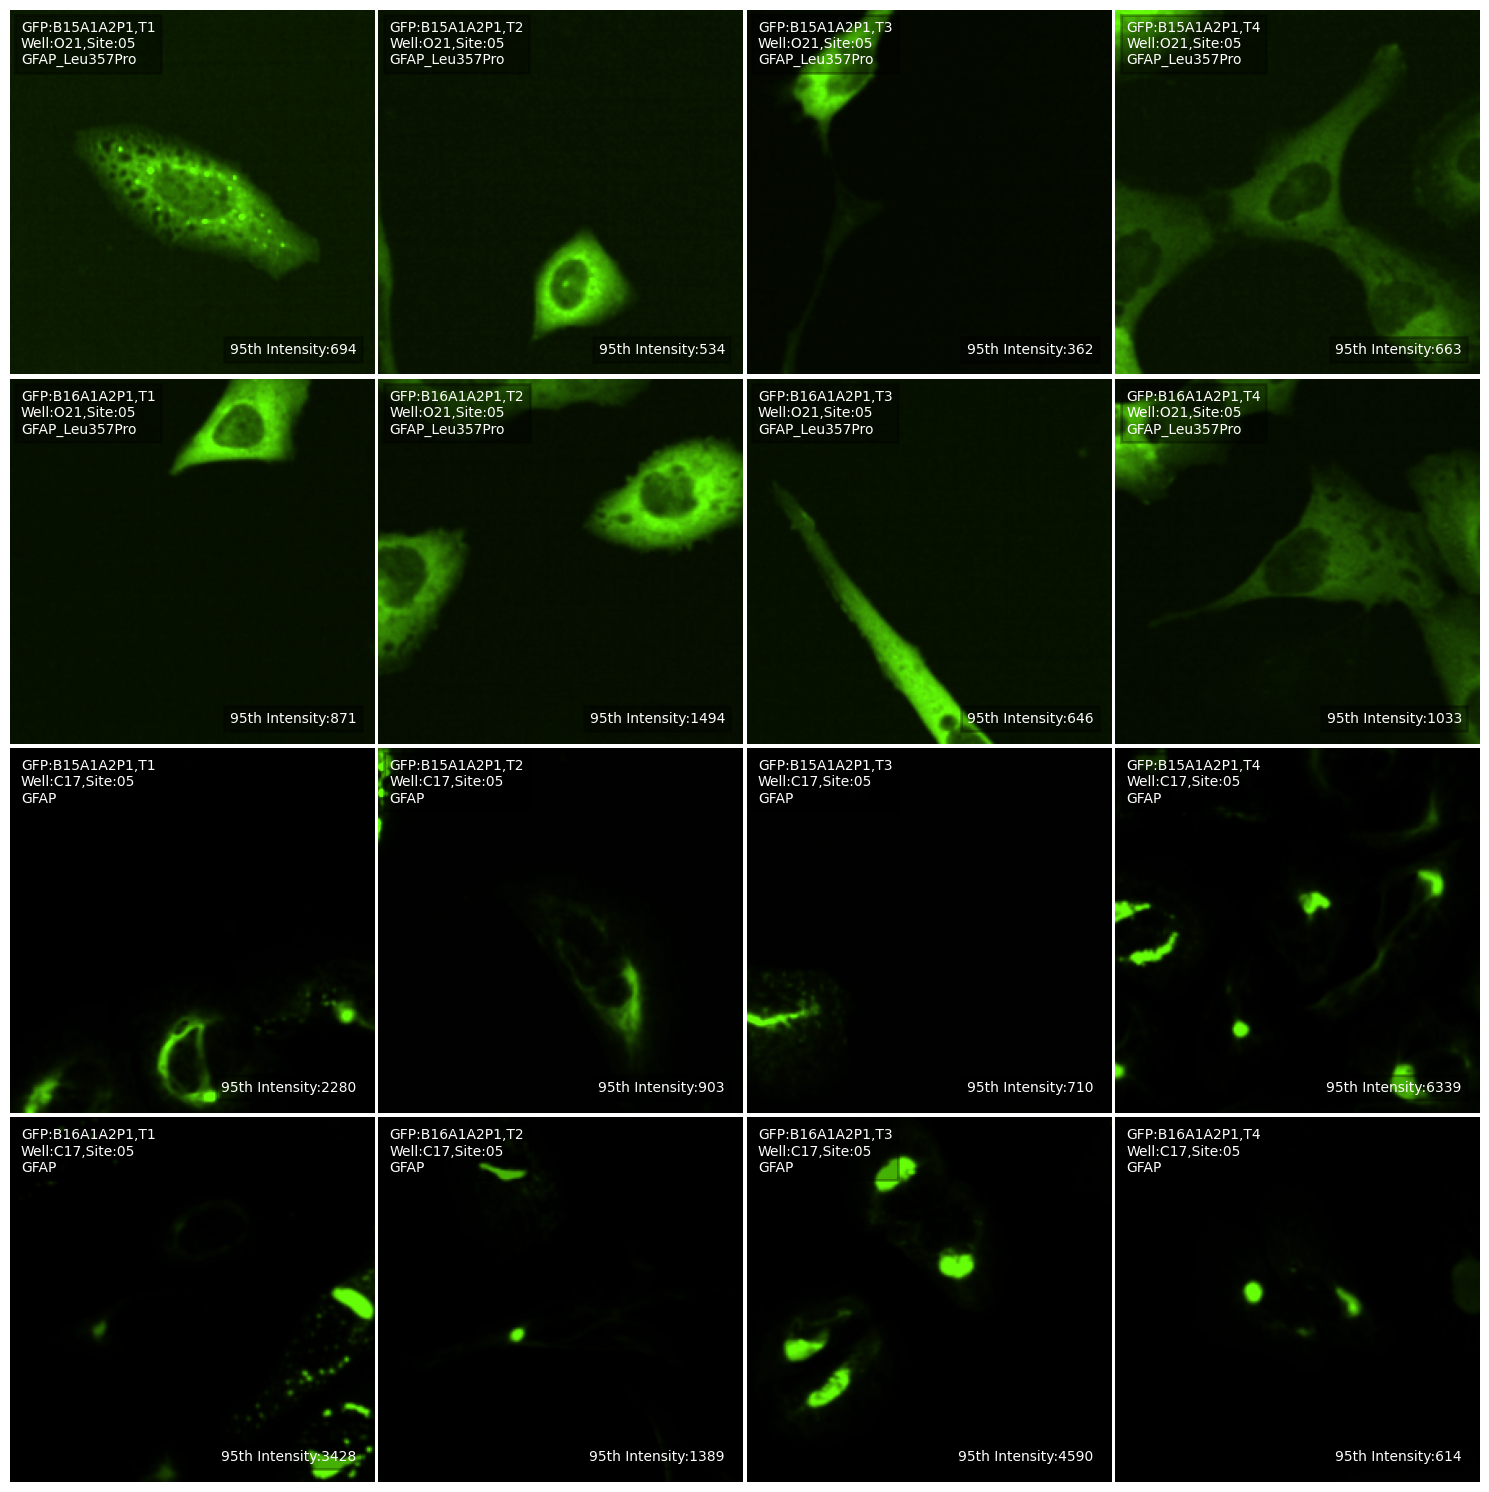

<Figure size 640x480 with 0 Axes>

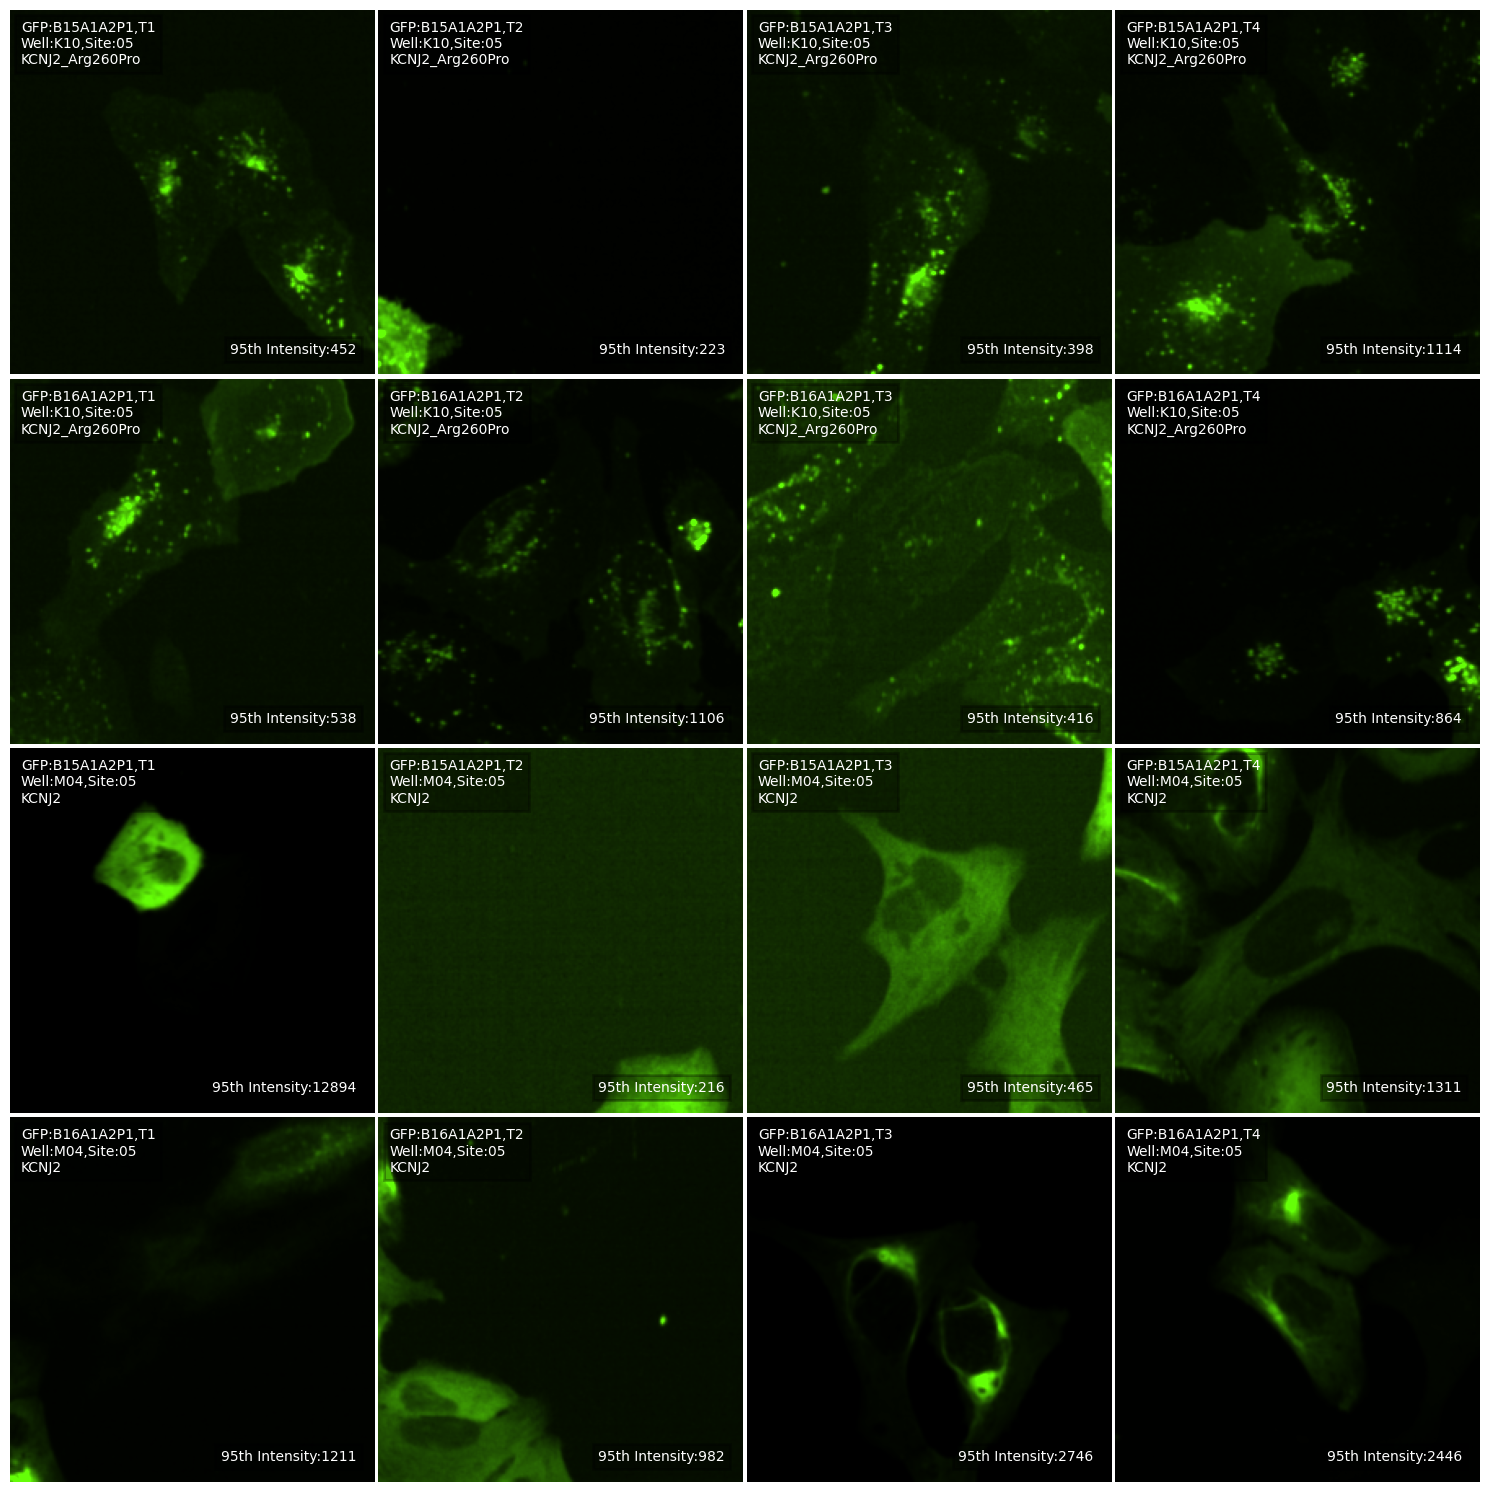

In [32]:
# Compute distances from edges and find the most centered well
def compute_distance_cell(row, col, edge=1080):
    return min(row - 1, edge - row, col - 1, edge - col)  # Distance from nearest edge
    

def plot_allele_cell(pm, variant, sel_channel, auroc_df, site="05", max_intensity=0.99, display=False, imgs_dir=TIFF_IMGS_DIR, output_dir=out_cells_dir):
    cmap = channel_to_cmap(sel_channel)
    channel = channel_dict[sel_channel]
    auroc = auroc_df.filter(pl.col("allele_0")==variant)["AUROC_Mean"].mean()

    # if os.path.exists(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png")):
    #     print(f"Image for {variant} already exists.")
        # return None

    ## get the number of wells/images per allele
    wt = variant.split("_")[0]
    wt_wells = pm.filter(pl.col("gene_allele") == wt).select("imaging_well").to_pandas().values.flatten()
    var_wells = pm.filter(pl.col("gene_allele") == variant).select("imaging_well").to_pandas().values.flatten()
    plate_map = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name").to_pandas().values.flatten()

    if len(wt_wells) > 1:
        # Get coordinates of wells
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in wt_wells])]
        # Sort wells by max distance from edges (descending)
        wt_wells = [max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]]

    pm_var = pm.filter((pl.col("imaging_well").is_in(np.concatenate([wt_wells, var_wells])))&(pl.col("plate_map_name").is_in(plate_map))).sort("node_type")
    # print(pm_var)
    plt.clf()

    fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    # fig2, axes2 = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    for wt_var, pm_row in enumerate(pm_var.iter_rows(named=True)):
        # print(pm_row)
        if pm_row["node_type"] == "allele":
            well = var_wells[0]
            allele = variant
        else:
            well = wt_wells[0]
            allele = wt

        for i in range(8):
            plot_idx = i+wt_var*4*2
            if i < 4:
                sel_plate = pm_row["imaging_plate_R1"]
            else:
                sel_plate = pm_row["imaging_plate_R2"]
                
            batch = batch_dict[sel_plate.split("_")[0]]
            batch_img_dir = f'{imgs_dir}/{batch}/images'
            letter = well[0]
            row = letter_dict[letter]
            col = well[1:3]
            
            # print(i, allele, well)
            plate_img_dir = plate_dict[sel_plate][f"T{i%4+1}"]
            img_file = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"
            img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            # print(np.percentile(img, 99) / np.median(img), np.percentile(img, 99) / np.percentile(img, 25))

            ## Full images
            # axes2.flatten()[plot_idx].imshow(img, vmin=0, vmax=np.percentile(img, max_intensity*100), cmap=cmap)
            # plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
            # axes2.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
            #         verticalalignment='top', horizontalalignment='left', transform=axes2.flatten()[plot_idx].transAxes,
            #         bbox=dict(facecolor='black', alpha=0.3, linewidth=2))

            ## Draw cells
            cell_allele_coord_df = crop_allele(allele, batch_profiles[batch], sel_plate.split("P")[0], f"T{i%4+1}", site=site[-1]) # "2024_01_19_B7A1R1_P4T1"
            cell_allele_coord_df = cell_allele_coord_df.with_columns(
                pl.struct("Cells_AreaShape_Center_X", "Cells_AreaShape_Center_Y") # 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y'
                .map_elements(lambda x: compute_distance_cell(x['Cells_AreaShape_Center_X'], x['Cells_AreaShape_Center_Y']), return_dtype=pl.Float32).cast(pl.Int16)
                .alias('dist2edge')
            ).sort(by=["dist2edge","Cells_AreaShape_Area"], descending=[True,True]).filter(pl.col("Cells_AreaShape_Area")>5000)
            # print(allele, sel_plate, f"T{i%4+1}", site[-1])
            # print(cell_allele_coord_df.select(pl.col(["dist2edge","Cells_AreaShape_Area","Metadata_ObjectNumber"])))
            # display(cell_allele_coord_df)
            
            if cell_allele_coord_df.is_empty():
                axes.flatten()[plot_idx].set_visible(False)
                # print(i, allele, well)
                continue
            else:
                plot_yet = 0
                for cell_idx, cell_row in enumerate(cell_allele_coord_df.head(10).iter_rows(named=True)):
                    if plot_yet:
                        break
                    x, y = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
                    # x, y = int(cell_allele_coord_df["Cells_AreaShape_Center_X"].to_numpy()[0]), int(cell_allele_coord_df["Cells_AreaShape_Center_Y"].to_numpy()[0])
                    ## flip the x and y for visualization
                    img_sub = img[
                        y-112:y+112, x-112:x+112
                    ]
                    ## skip the subimage due to poor cell quality
                    if img_sub.shape[0] == 0 or img_sub.shape[1] == 0 or np.percentile(img_sub, 90) <= np.median(img) or np.var(img_sub) < 1e4:
                        continue
                    axes.flatten()[plot_idx].imshow(img_sub, vmin=0, vmax=np.percentile(img_sub, max_intensity*100), cmap=cmap)  ## np.percentile(img_sub, max_intensity*100)
                    plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
                    axes.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
                            verticalalignment='top', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                            bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    int_95 = str(int(round(np.percentile(img_sub, 95))))
                    axes.flatten()[plot_idx].text(0.95, 0.05, f"95th Intensity:{int_95}", color='white', fontsize=10,
                                verticalalignment='bottom', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                                bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    axes.flatten()[plot_idx].axis("off")
                    plot_yet = 1

                # axes.flatten()[plot_idx].set_visible(False)
                # x_min, y_min, x_max, y_max = int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_Y"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_Y"].to_numpy()[0])
                # print(x_min, y_min, x_max, y_max)
            #     for cell_idx, cell_row in enumerate(cell_allele_coord_df.head().iter_rows(named=True)):
            #         x_nuc, y_nuc = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
            #         # Create a Rectangle patch
            #         rect = patches.Rectangle((x_nuc-5, y_nuc-5), 10, 10, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         rect = patches.Rectangle((x-128, y-128), 256, 256, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         # x_min, y_min, x_max, y_max = int(cell_row["Cells_AreaShape_BoundingBoxMinimum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMinimum_Y"]), \
            #         #                              int(cell_row["Cells_AreaShape_BoundingBoxMaximum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMaximum_Y"])
            #         # print(x_min, y_min, x_max, y_max)
            #         # rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='red', facecolor='none')
            #         # Add the patch to the Axes
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         break
            # int_95 = str(int(round(np.percentile(img, 95))))
            # axes2.flatten()[plot_idx].axhline(y=img.shape[1]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].axvline(x=img.shape[0]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].text(0.95, 0.05, f"95th Percentile\nIntensity:{int_95}", color='white', fontsize=12,
            #                verticalalignment='bottom', horizontalalignment='right', transform=axes2.flatten()[plot_idx].transAxes)
            # axes2.flatten()[plot_idx].axis("off")
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)
    
    if display:
        plt.show()

    if output_dir:
        fig.savefig(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png"), dpi=400, bbox_inches='tight')
        plt.close(fig)

plot_allele_cell(meta_data, "GFAP_Leu357Pro", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.999, display=True, output_dir=out_cells_dir)
plot_allele_cell(meta_data, "KCNJ2_Arg260Pro", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.999, display=True, output_dir=out_cells_dir)